# HAIC HIWC

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from ccic.plotting import set_style

set_style()
DATA_PATH = Path("/home/simonpf/copper/ccic")

## Resample retrieval results

In [2]:
from ccic.validation import get_latlon_bins
cpcir_file = DATA_PATH / "results/haic/ccic_cpcir_201401010000.nc"
bins_cpcir = get_latlon_bins(cpcir_file)
gridsat_file = DATA_PATH / "results/haic/ccic_gridsat_201401010000.nc"
bins_gridsat = get_latlon_bins(gridsat_file)

In [3]:
from ccic.validation import resample_data

haic_files = sorted(list(
    (DATA_PATH / "validation/haic_hiwc/results_down/").glob("*.nc")
))

results = {}
groups = ["LargePlateAggregate", "LargeColumnAggregate", "8-ColumnAggregate"]
name = "cpcir"
for name, bins, in zip(["cpcir", "gridsat"], [bins_cpcir, bins_gridsat]):
    for group in groups:
        scene = 0
        for haic_file in haic_files:
            result_file_down = Path(haic_file)
            result_file_up = result_file_down.parent
            result_file_up = result_file_up.parent / result_file_up.name.replace("down", "up") / result_file_down.name.replace("down", "up")

            rs = xr.load_dataset(result_file_up, group=group).resample(time="1min").mean()
            rs_down = xr.load_dataset(result_file_down, group=group).resample(time="1min").mean()
            
            iwc_down = rs_down.iwc.data
            alt_mask = np.tile(rs.altitude.data[None], (rs.time.size, 1))
            alt_mask = alt_mask >= rs.sensor_position.data[..., None] - 250
            iwc_down[alt_mask] = np.nan

            iwc_up = rs.iwc.data
            alt_mask = np.tile(rs.altitude.data[None], (rs.time.size, 1))
            alt_mask = alt_mask > rs.sensor_position.data[..., None] + 250
            iwc_down[alt_mask] = iwc_up[alt_mask]
    
            rs["iwc"].data = iwc_down
            iwp = np.trapz(rs.iwc.data, x=rs.altitude.data, axis=-1)
            rs["iwp"] = (("time",), iwp)
            rs["scene"] = (("time"), scene * np.ones(rs.time.size))

            resample_data(
                rs,
                ["iwc", "rwc", "temperature"],
                bins[1],
                bins[0],
                DATA_PATH / "validation/haic_hiwc/radar_resampled/",
                f"radar_{name}_{group}_{{year:04}}{{month:02}}{{day:02}}{{hour:02}}.nc"
            )

## Resample in-situ results

In [6]:
import pandas as pd
in_situ_files = sorted(list((DATA_PATH / "validation/haic_hiwc/in_situ/").glob("*.csv")))

def read_csv(path):
    df = pd.read_csv(
        path,
        skiprows=1,
        sep=",",
        names=["time", "latitude", "longitude", "altitude", "twc"],
        parse_dates=["time"]
    )
    df.loc[df.twc < 0.0, "twc"] = np.nan
    df = df.set_index("time")
    return xr.Dataset(df)

for name, bins, in zip(["cpcir", "gridsat"], [bins_cpcir, bins_gridsat]):
    for in_situ_file in in_situ_files:
        rs = read_csv(in_situ_file)
        resample_data(
            rs,
            ["twc"],
            bins[1],
            bins[0],
            DATA_PATH / "validation/haic_hiwc/in_situ_resampled/",
            f"in_situ_{name}_{group}_{{year:04}}{{month:02}}{{day:02}}{{hour:02}}.nc"
        )

NameError: name 'bins_cpcir' is not defined

# Load collocated data

In [2]:
in_situ_path = DATA_PATH / "validation/haic_hiwc/in_situ_resampled"
radar_path = DATA_PATH / "validation/haic_hiwc/radar_resampled"
ccic_path = DATA_PATH / "results/haic/"

particles = ["LargePlateAggregate", "LargeColumnAggregate", "8-ColumnAggregate"]
in_situ_files = sorted(list(in_situ_path.glob("*cpcir*.nc")))
ccic_files = sorted(list(ccic_path.glob("*cpcir*.nc")))

In [3]:
short_names = {
    "LargePlateAggregate": "lpa",
    "LargeColumnAggregate": "lca",
    "8-ColumnAggregate": "8ca"
}

In [4]:
particles = ["LargePlateAggregate", "LargeColumnAggregate", "8-ColumnAggregate"]
in_situ_files = sorted(list(in_situ_path.glob("*cpcir*.nc")))

cpcir_files = sorted(list(ccic_path.glob("*cpcir*.nc")))

citation_data = []
results_cpcir = []

for ccic_file in cpcir_files:
    
    date = ccic_file.name.split("_")[-1][:10]
    in_situ_files = sorted(list(in_situ_path.glob(f"*cpcir*{date}.nc")))
    radar_files = sorted(list(radar_path.glob(f"radar_cpcir_{particles[0]}_{date}.nc")))
        
    if len(radar_files) == 0 and len(in_situ_files) == 0:
        continue
        
    ccic_data = xr.load_dataset(ccic_file)

    dims = ("time", "latitude", "longitude", "altitude")

    for particle in particles:
        radar_files = sorted(list(radar_path.glob(f"radar_cpcir_{particle}_{date}.nc")))
        if len(radar_files) > 0:
            radar_data = xr.load_dataset(radar_files[0])
            ccic_data[f"tiwc_radar_{short_names[particle]}"] = (dims, radar_data.iwc.data.astype("float32"))
            ccic_data["temperature"] = (dims, radar_data.temperature.data.astype("float32"))
        else:
            ccic_data[f"tiwc_radar_{short_names[particle]}"] = (
                dims, np.nan * np.ones_like(ccic_data.tiwc.data.astype("float32"))
            )
            ccic_data["temperature"] = (
                dims, np.nan * np.ones_like(ccic_data.tiwc.data.astype("float32"))
            )

    if len(in_situ_files) > 0:
        in_situ_data = xr.load_dataset(in_situ_files[0])
        ccic_data["tiwc_in_situ"] = (dims, in_situ_data.twc.data.astype("float32"))
    else:
        ccic_data["tiwc_in_situ"] = (
            dims, np.nan * np.ones_like(ccic_data.tiwc.data.astype("float32"))
        )
    results_cpcir.append(ccic_data)

results_cpcir = xr.concat(results_cpcir, "time")

In [5]:
particles = ["LargePlateAggregate", "LargeColumnAggregate", "8-ColumnAggregate"]

ccic_path = Path("/home/simonpf/copper/ccic/results/haic/")
gridsat_files = sorted(list(ccic_path.glob("*gridsat*.nc")))

citation_data = []
results_gridsat = []

for ccic_file in gridsat_files:
    
    date = ccic_file.name.split("_")[-1][:10]
    in_situ_files = sorted(list(in_situ_path.glob(f"*gridsat*{date}.nc")))
    radar_files = sorted(list(radar_path.glob(f"radar_gridsat_{particles[0]}_{date}.nc")))
    
    if len(radar_files) == 0 and len(in_situ_files) == 0:
        continue
        
    ccic_data = xr.load_dataset(ccic_file)[{"time": [0]}]

    dims = ("time", "latitude", "longitude", "altitude")

    for particle in particles:
        radar_files = sorted(list(radar_path.glob(f"radar_gridsat_{particle}_{date}.nc")))
        if len(radar_files) > 0:
            radar_data = xr.load_dataset(radar_files[0])[{"time": [0]}]
            ccic_data[f"tiwc_radar_{short_names[particle]}"] = (dims, radar_data.iwc.data)
            ccic_data["temperature"] = (dims, radar_data.temperature.data)
        else:
            ccic_data[f"tiwc_radar_{short_names[particle]}"] = (
                dims, np.nan * np.ones_like(ccic_data.tiwc.data.astype("float32"))
            )
            ccic_data["temperature"] = (
                dims, np.nan * np.ones_like(ccic_data.tiwc.data.astype("float32"))
            )

    if len(in_situ_files) > 0:
        in_situ_data = xr.load_dataset(in_situ_files[0])[{"time": [0]}]
        ccic_data["tiwc_in_situ"] = (dims, in_situ_data.twc.data)
    else:
        ccic_data["tiwc_in_situ"] = (
            dims, np.nan * np.ones_like(ccic_data.tiwc.data)
        )
    results_gridsat.append(ccic_data)

results_gridsat = xr.concat(results_gridsat, "time")

In [6]:
def get_tiwc_in_situ_radar(data, particle):
    """
    Extract collocations between in_situ in-situ measurements and radar retrievals.
    """
    tiwc_ref = np.maximum(data.tiwc_in_situ.data, 0.0)
    tiwc = data[f"tiwc_radar_{short_names[particle]}"].data * 1e3
    valid = (tiwc_ref >= 0.0) * (tiwc >= 0.0)
    return tiwc_ref[valid], tiwc[valid]

def get_tiwc_in_situ_ccic(data):
    """
    Extract collocations between in_situ in-situe measurements and CCIC retrievals.
    """
    tiwc_ref = np.maximum(data.tiwc_in_situ.data, 0.0)
    tiwc = data.tiwc.data
    valid = (tiwc_ref >= 0.0) * (tiwc >= 0.0)
    return tiwc_ref[valid], tiwc[valid]

def get_tiwc_radar_ccic(data, particle):
    """
    Extract collocations between in_situ in-situe measurements and CCIC retrievals.
    """
    tiwc_ref = data[f"tiwc_radar_{short_names[particle]}"].data * 1e3
    tiwc = data.tiwc.data
    valid = np.all(tiwc_ref >= 0.0, -1) * np.all(tiwc >= 0.0, -1)
    return tiwc_ref[valid], tiwc[valid]

## Results

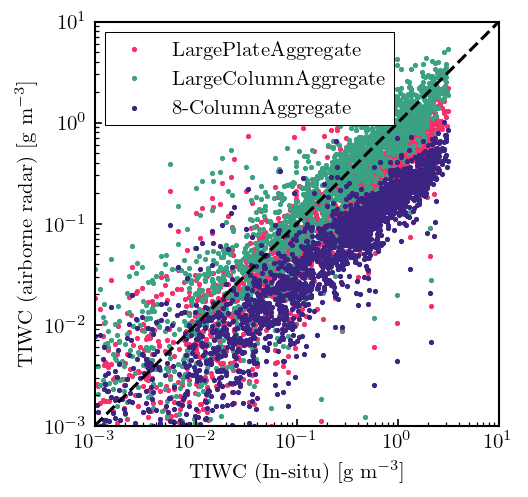

In [7]:
f, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))

x = np.logspace(-3, 1, 101)
ax.plot(x, x, c="k", ls="--")

bins = np.logspace(-3, 1, 31)
iwc_ref, iwc = get_tiwc_in_situ_radar(results_cpcir, "LargePlateAggregate")
#x = 0.5 * (bins[1:] + bins[:-1])
#y = np.histogram2d(iwc_ref, iwc, bins=bins)[0]
#ax.contour(x, x, y.T, cmap="Reds")
plt.scatter(iwc_ref, iwc, label="LargePlateAggregate", s=4)
#bias = 100 * (iwc - iwc_ref).mean() / iwc_ref.mean()
#print(bias)
#
iwc_ref, iwc = get_tiwc_in_situ_radar(results_cpcir, "LargeColumnAggregate")
y = np.histogram2d(iwc_ref, iwc, bins=bins)[0]
#ax.contour(x, x, y.T, cmap="Blues")
ax.scatter(iwc_ref, iwc, label="LargeColumnAggregate", s=4)
#bias = 100 * (iwc - iwc_ref).mean() / iwc_ref.mean()
#print(bias)
iwc_ref, iwc = get_tiwc_in_situ_radar(results_cpcir, "8-ColumnAggregate")
#y = np.histogram2d(iwc_ref, iwc, bins=bins)[0]
#ax.contour(x, x, y.T, cmap="Greens")
#
#iwc_ref, iwc = get_iwc_in_situ_radar(results_gridsat, "8-ColumnAggregate")
ax.scatter(iwc_ref, iwc, label="8-ColumnAggregate", s=4)
#bias = 100 * (iwc - iwc_ref).mean() / iwc_ref.mean()
#print(bias)

ax.set_xlim(1e-3, 1e1)
ax.set_ylim(1e-3, 1e1)
ax.set_aspect(1)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("TIWC (In-situ) [g m$^{-3}$]")
ax.set_ylabel("TIWC (airborne radar) [g m$^{-3}$]")
ax.legend()

f.savefig("../figures/radar_only_haic.pdf", bbox_inches="tight")

In [8]:
def get_tiwp_radar_ccic(data, particle):
    """
    Extract collocations between in_situ in-situe measurements and CCIC retrievals.
    """
    tiwc_ref = data[f"tiwc_radar_{short_names[particle]}"].data * 1e3
    tiwc = data.tiwc.data
    alt = data.altitude.data
    tiwp_ref = tiwc_ref.sum(-1)
    tiwp = data.tiwp.data
    
    print("0 ::", (tiwp_ref >= 0.0).sum())
    print("1 ::", (tiwp >= 0.0).sum())
    
    valid = (tiwp_ref >= 0.0) * (tiwp >= 0.0)
    return tiwp_ref[valid], tiwp[valid]

/tmp/ipykernel_2381391/2198626692.py:22: UserWarning: Log scale: values of z <= 0 have been masked
  m_tiwc = ax.contourf(x, x, y.T, levels=np.logspace(-2, 2, 9), norm=norm, extend="both")


0 :: 2654
1 :: 24334036


/tmp/ipykernel_2381391/2198626692.py:52: RuntimeWarning: invalid value encountered in divide
  y /= np.sum(y * np.diff(bins)[None], axis=1, keepdims=True)
/tmp/ipykernel_2381391/2198626692.py:55: UserWarning: Log scale: values of z <= 0 have been masked
  m_tiwp = ax.contourf(x, x, y.T, levels=np.logspace(-2, 2, 9), norm=norm, extend="both")


0 :: 454
1 :: 2523059


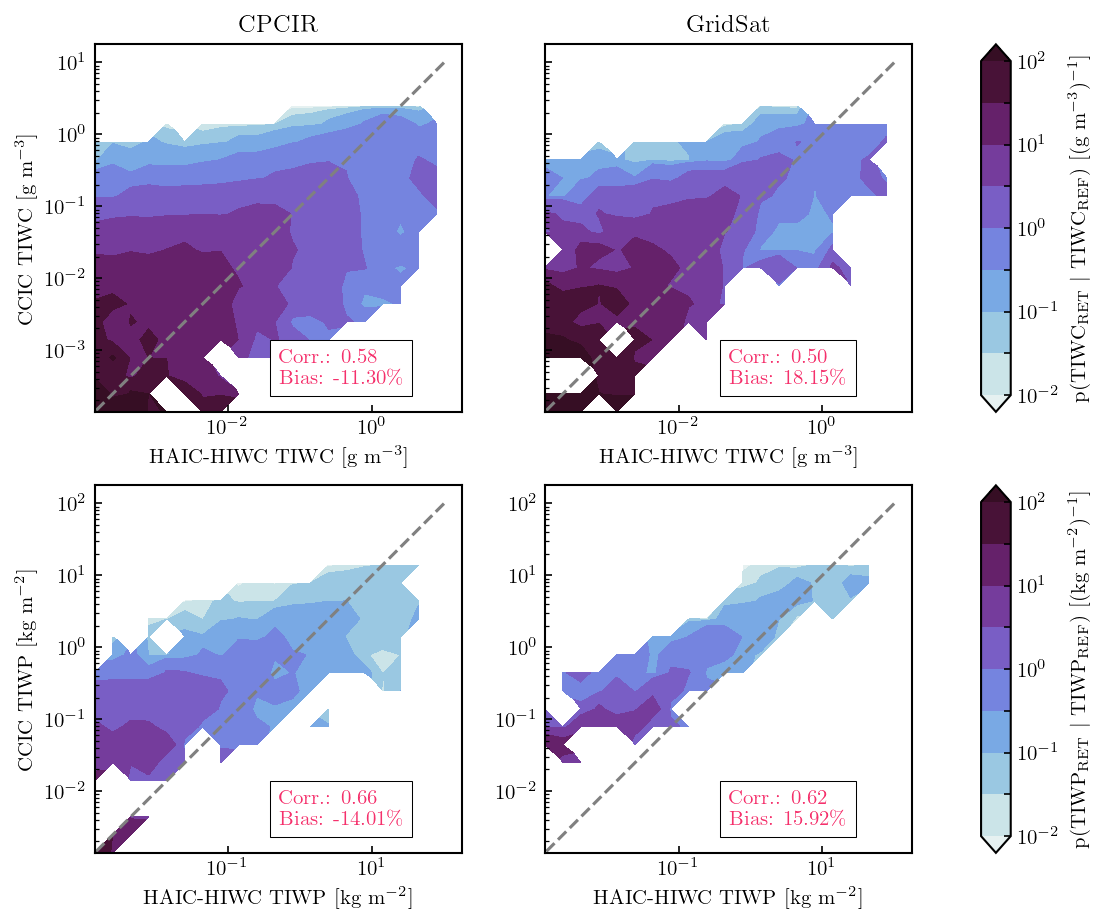

In [14]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

gs = GridSpec(2, 3, width_ratios=(1.0, 1.0, 0.075), wspace=0.2, hspace=0.20)
fig = plt.figure(figsize=(8, 7))

norm = LogNorm(1e-2, 1e2)
txtcol = "C0"
diagcol = "orangered"
names = ["CPCIR", "GridSat"]

for i, (name, results) in enumerate(zip(names, [results_cpcir, results_gridsat])):
    
    ax = fig.add_subplot(gs[0, i])
    
    bins = np.logspace(-4, 1, 21)
    tiwc_ref, tiwc = get_tiwc_radar_ccic(results, "LargeColumnAggregate")
    y = np.histogram2d(tiwc_ref.ravel(), tiwc.ravel(), bins=bins, density=True)[0]
    y /= np.sum(y * np.diff(bins)[None], axis=1, keepdims=True)
    #m_tiwc = ax.pcolormesh(bins, bins, np.maximum(y.T, 1e-3), norm=norm, rasterized=True)
    x = 0.5 * (bins[1:] + bins[:-1])
    m_tiwc = ax.contourf(x, x, y.T, levels=np.logspace(-2, 2, 9), norm=norm, extend="both")
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect(1.0)
    
    ax.plot(bins, bins, c="grey", ls="--")

    corr = np.corrcoef(tiwc_ref.ravel(), tiwc.ravel())[0, 1]
    bias = (tiwc - tiwc_ref).mean() / tiwc_ref.mean()
    props = dict(facecolor='white', edgecolor="k")
    ax.text(0.05, 3.0e-4, f"Corr.: {corr:0.2f} \n Bias: {100 * bias:0.2f}\%",
            fontsize=10, color=txtcol, ha="left", va="bottom", bbox=props)
    
    ax.set_title(f"{name}", loc="center")

    if i == 0:
        ax.set_ylabel("CCIC TIWC [g m$^{-3}$]")
        
    ax.set_xlabel("HAIC-HIWC TIWC [g m$^{-3}$]")

    if i == 1:
        for l in ax.yaxis.get_ticklabels():
            l.set_visible(False)
            
            
    ax = fig.add_subplot(gs[1, i])
    bins = np.logspace(-3, 2, 21)
    tiwp_ref, tiwp = get_tiwp_radar_ccic(results, "LargeColumnAggregate")
    y = np.histogram2d(tiwp_ref, tiwp, bins=bins, density=True)[0]
    y /= np.sum(y * np.diff(bins)[None], axis=1, keepdims=True)
    #m_tiwp = ax.pcolormesh(bins, bins, np.maximum(y.T, 1e-3), norm=norm, rasterized=True)
    x = 0.5 * (bins[1:] + bins[:-1])
    m_tiwp = ax.contourf(x, x, y.T, levels=np.logspace(-2, 2, 9), norm=norm, extend="both")
    ax.plot(bins, bins, c="grey", ls="--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect(1.0)

    corr = np.corrcoef(tiwp_ref, tiwp)[0, 1]
    bias = (tiwp - tiwp_ref).mean() / tiwp_ref.mean()
    ax.text(0.5, 3e-3, f"Corr.: {corr:0.2f} \n Bias: {100 * bias:0.2f}\%",
            fontsize=10, color=txtcol, ha="left", va="bottom", bbox=props)
    
    ax.set_xlabel("HAIC-HIWC TIWP [kg m$^{-2}$]")
    
    if i == 0:
        ax.set_ylabel("CCIC TIWP [kg m$^{-2}$]")
    
ax = fig.add_subplot( gs[0, -1])
plt.colorbar(m_tiwc, cax=ax, label=r"p(TIWC$_\text{RET}$ $|$ TIWC$_\text{REF}$) [(g m$^{-3}$)$^{-1}$]", extend="both")
ax = fig.add_subplot( gs[1, -1])
plt.colorbar(m_tiwp, cax=ax, label=r"p(TIWP$_\text{RET}$ $|$ TIWP$_\text{REF}$) [(kg m$^{-2}$)$^{-1}$]", extend="both")
fig.savefig("../figures/haic_scatter_radar.pdf", bbox_inches="tight")

# Case study

In [15]:
radar_files = sorted(list((DATA_PATH / "validation/haic_hiwc/results_down").glob("*.nc")))

In [16]:
def load_radar_results(down_file, group="LargeColumnAggregate"):
    result_file_down = Path(down_file)
    result_file_up = result_file_down.parent
    result_file_up = result_file_up.parent / result_file_up.name.replace("down", "up") / result_file_down.name.replace("down", "up")

    rs = xr.load_dataset(result_file_up, group=group).resample(time="1min").mean()
    rs_down = xr.load_dataset(result_file_down, group=group).resample(time="1min").mean()
    
    iwc_down = rs_down.iwc.data
    rwc_down = rs_down.rwc.data
    alt_mask = np.tile(rs.altitude.data[None], (rs.time.size, 1))
    alt_mask = alt_mask >= rs.sensor_position.data[..., None] - 250
    iwc_down[alt_mask] = np.nan
    rwc_down[alt_mask] = np.nan
    
    iwc_up = rs.iwc.data
    rwc_up = rs.rwc.data
    alt_mask = np.tile(rs.altitude.data[None], (rs.time.size, 1))
    alt_mask = alt_mask > rs.sensor_position.data[..., None] + 250
    iwc_down[alt_mask] = iwc_up[alt_mask]
    rwc_down[alt_mask] = rwc_up[alt_mask]
    
    rs["iwc"].data = iwc_down
    iwp = np.trapz(iwc_down, x=rs.altitude.data, axis=-1)
    rs["iwp"] = (("time",), iwp)
    rs["rwc"].data = rwc_down
    return rs

In [17]:
import pandas as pd

def read_in_situ_file(path):
    df = pd.read_csv(
        path,
        skiprows=1,
        sep=",",
        names=["time", "latitude", "longitude", "altitude", "twc"],
        parse_dates=["time"]
    )
    df.loc[df.twc < 0.0, "twc"] = np.nan
    df = df.set_index("time")
    return xr.Dataset(df)

In [18]:
from datetime import datetime
from pathlib import Path
from ccic.data.cpcir import gpm_mergeir, PROVIDER

start_time = datetime(2014, 1, 29, 21)
cpcir_file = Path("GPM/gpm_mergeir/merg_2014012921_4km-pixel.nc4")
if not cpcir_file.exists():
    file = gpm_mergeir.download(start_time, start_time)
cpcir_data = xr.load_dataset(cpcir_file)

In [19]:
from ccic.validation import great_circle_distance
radar_data = load_radar_results(radar_files[7], "LargeColumnAggregate")
lons = radar_data.longitude
lats = radar_data.latitude
time = radar_data.time
dist = np.array([great_circle_distance(lats[i], lons[i], lats[i + 1], lons[i + 1]) for i in range(lats.size - 1)])
dist = np.concatenate([[0], np.cumsum(dist)])
ccic_cpcir_data = xr.load_dataset(DATA_PATH / "results/haic/ccic_cpcir_201401292100.nc")
tiwp_cpcir = ccic_cpcir_data.tiwp.copy()
ccic_gridsat_data = xr.load_dataset(DATA_PATH / "results/haic/ccic_cpcir_201401292100.nc")[{"time": 0}].drop_vars("time")
tiwp_gridsat = ccic_gridsat_data.tiwp.copy()

In [20]:
in_situ_data = read_in_situ_file(DATA_PATH / "validation/haic_hiwc/in_situ/friendly_f20-2014-01-29-192735-IKPV5.csv")
in_situ_data = in_situ_data.resample(time="5min").mean()
lons_in_situ = in_situ_data.longitude.data
lats_in_situ = in_situ_data.latitude.data
time_in_situ = in_situ_data.time.data

In [21]:
from ccic.data.cpcir import CPCIR_GRID
cpcir_files = [
    DATA_PATH / "results/haic/ccic_cpcir_201401291900.nc",
    DATA_PATH / "results/haic/ccic_cpcir_201401292000.nc",
    DATA_PATH / "results/haic/ccic_cpcir_201401292100.nc",
    DATA_PATH / "results/haic/ccic_cpcir_201401292200.nc",
    DATA_PATH / "results/haic/ccic_cpcir_201401292300.nc",
    DATA_PATH / "results/haic/ccic_cpcir_201401300000.nc",
]
ccic_cpcir_data = xr.concat(
    [xr.load_dataset(filename) for filename in cpcir_files],
    dim="time"
)
tiwp = ccic_cpcir_data.tiwp[{"time": 5}]
ct = ccic_cpcir_data.cloud_type[{"time": 5}]
# Obs from first time step are missing.
ccic_cpcir_data = ccic_cpcir_data[{"time": slice(1, None, 2)}]
ccic_cpcir_ct = ccic_cpcir_data.cloud_type.interp(time=time, latitude=lats, longitude=lons, method="nearest")

lon_min = ccic_cpcir_data.longitude.data.min()
lon_start = np.where(cpcir_data.lon.data >= lon_min)[0][0]
lat_min = ccic_cpcir_data.latitude.data.min()
lat_start = np.where(cpcir_data.lat.data >= lat_min)[0][0]
area = CPCIR_GRID[-(lat_start + 256): -lat_start, lon_start: lon_start + 256]

cpcir_tbs = cpcir_data.interp(lat=ccic_cpcir_data.latitude, lon=ccic_cpcir_data.longitude)
ccic_cpcir_data = ccic_cpcir_data.interp(time=time, latitude=lats, longitude=lons)

In [22]:
from ccic.plotting import get_cloud_type_cmap, CLOUD_CLASSES
cloud_type_cmap = get_cloud_type_cmap()

In [23]:
from ccic.validation import get_dominant_cloud_type
dct = get_dominant_cloud_type(ct)

In [24]:
gridsat_files = [
    DATA_PATH / "results/haic/ccic_gridsat_201401291800.nc",
    DATA_PATH / "results/haic/ccic_gridsat_201401292100.nc",
    DATA_PATH / "results/haic/ccic_gridsat_201401300000.nc",
]
ccic_gridsat_data = xr.concat(
    [xr.load_dataset(filename) for filename in gridsat_files],
    dim="time"
)
ccic_gridsat_data = ccic_gridsat_data.interp(time=time, latitude=lats, longitude=lons)

In [25]:
import cartopy.crs as ccrs
from matplotlib.ticker import FixedLocator

def add_ticks(ax, lons, lats, left=True, bottom=True):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='none')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = left
    gl.bottom_labels = bottom
    gl.xlocator = FixedLocator(lons)
    gl.ylocator = FixedLocator(lats)

In [26]:
from pyresample import create_area_def
lon_min = tiwp_cpcir.longitude.data.min()
lon_max = tiwp_cpcir.longitude.data.max()
lat_min = tiwp_cpcir.latitude.data.min()
lat_max = tiwp_cpcir.latitude.data.max()
area = create_area_def(
    'my_area',
    {'proj': 'longlat', 'datum': 'WGS84'},
    area_extent=[lon_min, lat_min, lon_max, lat_max],
    shape=tiwp_cpcir[0].shape,
    units='degrees',
    description='Global 1x1 degree lat-lon grid'
)
lon_mask = (cpcir_data.lon.data >= lon_min) * (cpcir_data.lon.data <= lon_max)
lat_mask = (cpcir_data.lat.data >= lat_min) * (cpcir_data.lat.data <= lat_max)
cpcir_data = cpcir_data[{"lon": lon_mask, "lat": lat_mask}]

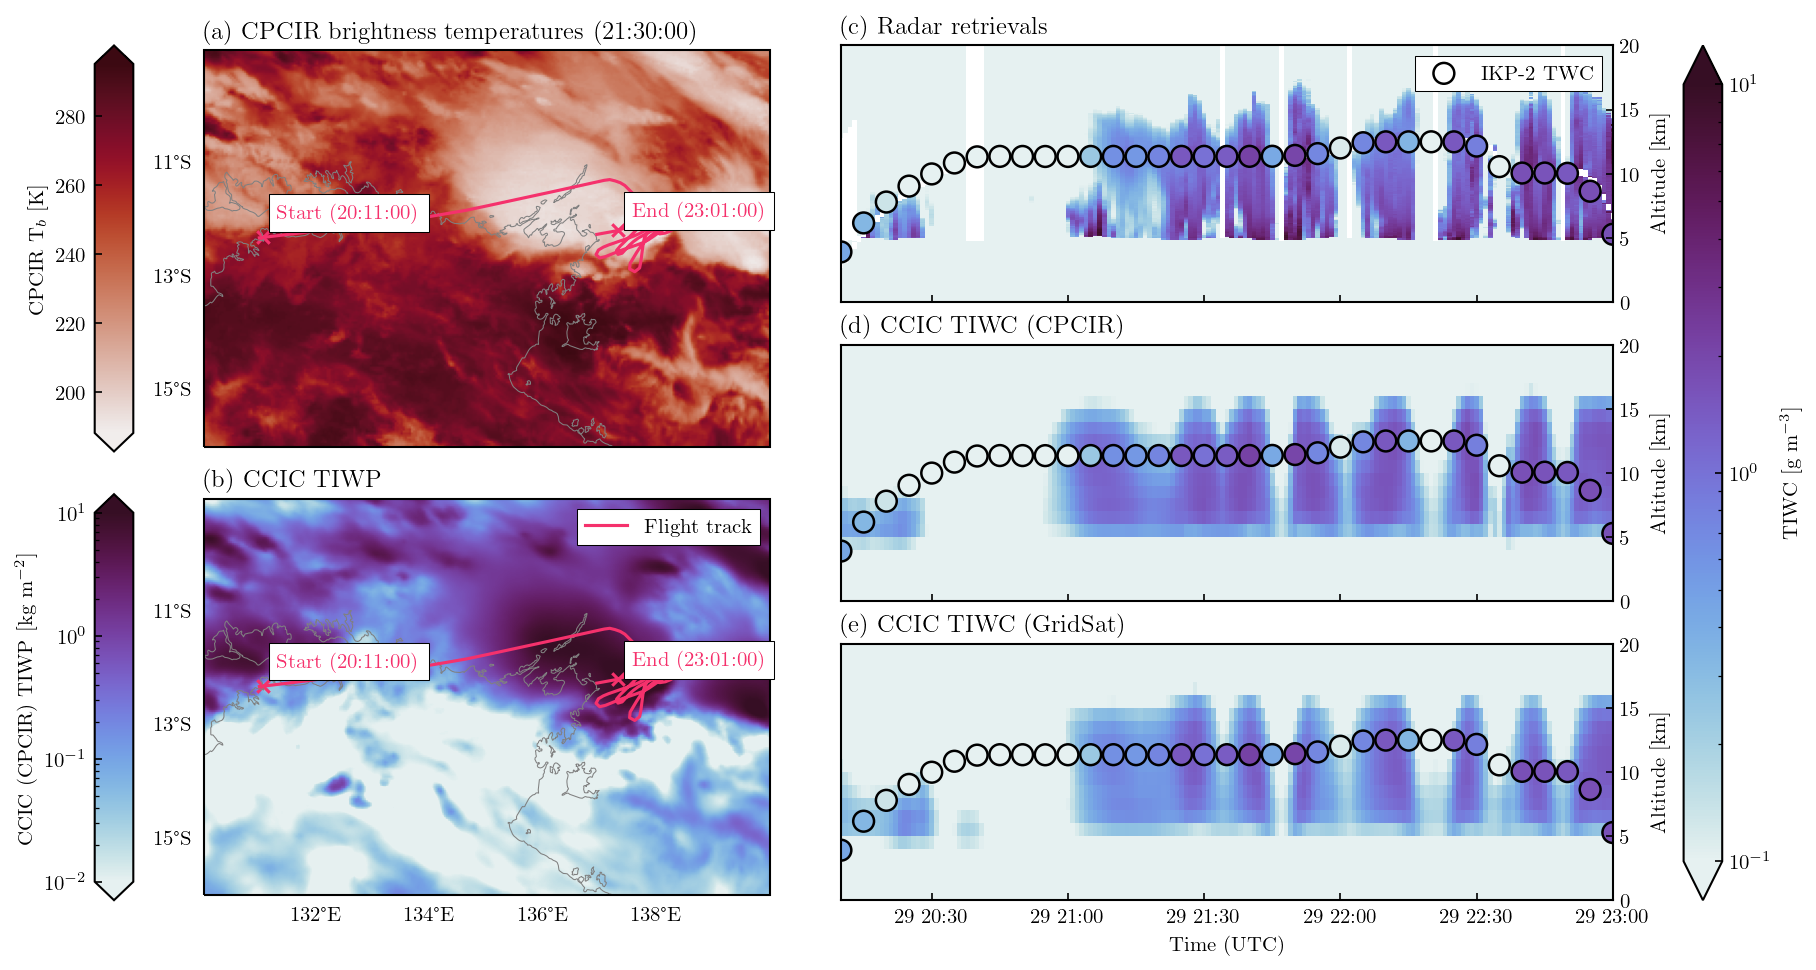

In [32]:
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14, 7.4))
gs = GridSpec(6, 4, width_ratios=[0.075, 1.1, 1.5, 0.075], wspace=0.2, hspace=0.4)

start = np.datetime64("2014-01-29T20:10:00", "s")
end = np.datetime64("2014-01-29T23:00:00", "s")

tiwp_norm = LogNorm(1e-2, 1e1)
tiwc_norm = LogNorm(1e-1, 1e1)

ind_start = np.where(radar_data.time > start)[0][0]
ind_end = np.where(radar_data.time > end)[0][0]
crs = area.to_cartopy_crs()

# CPCIR input
                 
ax = fig.add_subplot(gs[:3, 1], projection=crs)
ext = area.area_extent
ext = (ext[0], ext[2], ext[1], ext[3])
m = ax.imshow(cpcir_tbs.Tb.data[1], extent=ext, rasterized=True, cmap="cmo.amp")

lon_start = 130
lon_end = 140
lat_start = -16
lat_end = -9

ax.set_xlim(lon_start, lon_end)
ax.set_ylim(lat_start, lat_end)

ax.plot(radar_data.longitude.data, radar_data.latitude.data, c="C0")
##ax.plot(in_situ_data.longitude.data, in_situ_data.latitude.data, c="black")
#ax.text(radar_data.longitude.data[ind_start], radar_data.latitude.data[ind_start], "Start", color="red", ha="left", va="bottom")
##ax.scatter([radar_data.longitude.data[ind_start]], [radar_data.latitude.data[ind_start]], marker="x", color="red", zorder=10)
#ax.text(radar_data.longitude.data[ind_end], radar_data.latitude.data[ind_end], "End", color="red", ha="left", va="bottom")
#ax.scatter([radar_data.longitude.data[ind_end]], [radar_data.latitude.data[ind_end]], marker="x", color="red", zorder=10)
props = dict(facecolor='white', alpha=1.0, edgecolor="k")
ax.text(radar_data.longitude.data[ind_start] + 0.25, radar_data.latitude.data[ind_start] + 0.25, "Start (20:11:00)", color="C0", ha="left", va="bottom", bbox=props, fontsize=10)
ax.scatter([radar_data.longitude.data[ind_start]], [radar_data.latitude.data[ind_start]], marker="x", color="C0")
ax.text(radar_data.longitude.data[ind_end] + 0.25, radar_data.latitude.data[ind_end] + 0.25, "End (23:01:00)", color="C0", bbox=props, fontsize=10)
ax.scatter([radar_data.longitude.data[ind_end]], [radar_data.latitude.data[ind_end]], marker="x", color="C0")
add_ticks(ax, np.arange(lon_start, lon_end + 1, 2), np.arange(-17, -8, 2), bottom=False)
ax.set_title("(a) CPCIR brightness temperatures (21:30:00)", loc="left")


ax.coastlines(color="grey")

ax = fig.add_subplot(gs[:3, 0])
plt.colorbar(m, label="CPCIR T$_b$ [K]", cax=ax, location="left", extend="both")

# CPCIR TIWP

ax = fig.add_subplot(gs[3:6, 1], projection=crs)
m = ax.imshow(tiwp, extent=ext, norm=tiwp_norm, rasterized=True)
#m_ct = ax.contour(dct, vmin=0, vmax=9, cmap=cloud_type_cmap, levels=np.arange(9) + 0.5, extent=ext, origin="upper")

ax.plot(radar_data.longitude.data, radar_data.latitude.data, c="C0", label="Flight track")
ax.legend()
ax.set_xlim(lon_start, lon_end)
ax.set_ylim(lat_start, lat_end)

props = dict(facecolor='white', alpha=1.0, edgecolor="k")
ax.text(radar_data.longitude.data[ind_start] + 0.25, radar_data.latitude.data[ind_start] + 0.25, "Start (20:11:00)", color="C0", ha="left", va="bottom", bbox=props, fontsize=10)
ax.scatter([radar_data.longitude.data[ind_start]], [radar_data.latitude.data[ind_start]], marker="x", color="C0")
ax.text(radar_data.longitude.data[ind_end] + 0.25, radar_data.latitude.data[ind_end] + 0.25, "End (23:01:00)", color="C0", bbox=props, fontsize=10)
ax.scatter([radar_data.longitude.data[ind_end]], [radar_data.latitude.data[ind_end]], marker="x", color="C0")
ax.set_title("(b) CCIC TIWP", loc="left")

add_ticks(ax, np.arange(lon_start, lon_end + 1, 2), np.arange(-17, -8, 2), bottom=True)
ax.coastlines(color="grey")

ax = fig.add_subplot(gs[3:6, 0])
plt.colorbar(m, label="CCIC (CPCIR) TIWP [kg m$^{-2}$]", cax=ax, location="left", extend="both")

# Radar results

ax = fig.add_subplot(gs[:2, 2])
x = radar_data.time
y = radar_data.altitude.data / 1e3
ax.pcolormesh(x, y, radar_data.iwc.T * 1e3, norm=tiwc_norm, rasterized=True)
x = in_situ_data.time
y = in_situ_data.altitude / 1e3
ax.scatter(x, y, c=in_situ_data.twc, norm=tiwc_norm, label="IKP-2 TWC", s=100, edgecolor="k", linewidth=1.2)
ax.legend()
ax.set_xticklabels([])
ax.set_ylabel("Altitude [km]")
ax.set_xlim(start, end)
ax.set_ylim(0, 20)
ax.set_title("(c) Radar retrievals", loc="left")
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")

# CPCIR results

ax = fig.add_subplot(gs[2:4, 2])
x = ccic_cpcir_data.time.data
y = ccic_cpcir_data.altitude.data / 1e3
ax.pcolormesh(x, y, ccic_cpcir_data.tiwc.T, norm=tiwc_norm, rasterized=True)
#m_ct = ax.contour(x, y, ccic_cpcir_ct.data.T, cmap=cloud_type_cmap, levels=np.arange(9) + 0.5)
x = in_situ_data.time
ax.scatter(x, in_situ_data.altitude / 1e3, c=in_situ_data.twc, norm=tiwc_norm, edgecolor="k", s=100, linewidth=1.2)

ax.set_xlim(start, end)
ax.set_xticklabels([])
ax.set_ylabel("Altitude [km]")
ax.set_ylim(0, 20)
ax.set_title("(d) CCIC TIWC (CPCIR)", loc="left")
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")

# Gridsat results

ax = fig.add_subplot(gs[4:6, 2])
x = ccic_gridsat_data.time.data
y = ccic_gridsat_data.altitude.data / 1e3
m = ax.pcolormesh(x, y, ccic_gridsat_data.tiwc.T, norm=tiwc_norm, rasterized=True)
x = in_situ_data.time
ax.scatter(x, in_situ_data.altitude / 1e3, c=in_situ_data.twc, norm=tiwc_norm, edgecolor="k", s=100, linewidth=1.2)
ax.set_ylabel("Altitude [km]")
ax.set_title("(e) CCIC TIWC (GridSat)", loc="left")
ax.set_xlabel("Time (UTC)")

ax.set_xlim(start, end)
ax.set_ylim(0, 20)
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")

ax = fig.add_subplot(gs[:, -1])
plt.colorbar(m, label="TIWC [g m$^{-3}$]", cax=ax, extend="both")
fig.savefig("../figures/haic_case_study.pdf", bbox_inches="tight")

## Evaluate radar-only retrieval

In [28]:
from scipy.stats import binned_statistic
t_bins = np.linspace(220, 280, 21)
err_bins = np.linspace(-40, 40, 41)

def calculate_log_error_dist(temperature, tiwc_ref, tiwc):
    """
    Calculate distribution of logarithmic retrieval errors w.r.t. temperature.
    
    Args:
        temperature: Array containing the atmospheric temperature.
        tiwc_ref: Array containing the reference TIWC measurements.
        tiwc: Array containing the retrieved TIWC.
        
    Return:
        A tuple ``(mean_err, dist)`` containing ``mean_err``, the logarithmic mean
        error for for each temperature bin and ``dist``, the joint distribution of
        of logarithmic retrieval error by temperature.
    """
    valid = (tiwc_ref >= 0) * (tiwc >= 0) * (temperature < 273.15)
    temperature = temperature[valid]
    tiwc_ref = tiwc_ref[valid]
    tiwc = tiwc[valid]
    
    print(temperature.min(), temperature.max())
    
    tiwc_mean = binned_statistic(temperature, tiwc, bins=t_bins)[0]
    tiwc_ref_mean = binned_statistic(temperature, tiwc_ref, bins=t_bins)[0]
    
    mean_err = 10 * np.log10(tiwc_mean / tiwc_ref_mean)
    
    err = 10 * np.log10(tiwc / tiwc_ref)
    dist = np.histogram2d(temperature, err, bins=(t_bins, err_bins), density=True)[0].T
    dist /= dist.sum(0, keepdims=True)
    return mean_err, dist
    

In [29]:
tiwc_ref_8ca = results_cpcir.tiwc_in_situ.data
tiwc_8ca = results_cpcir.tiwc_radar_8ca.data * 1e3
temp = results_cpcir.temperature.data
valid = (tiwc_ref_8ca >= 0) * (tiwc_8ca >= 0) * (temp < 273.15)
temp = temp[valid]
tiwc_ref_8ca = tiwc_ref_8ca[valid]
tiwc_8ca = tiwc_8ca[valid]
mean_err_8ca, err_8ca = calculate_log_error_dist(temp, tiwc_ref_8ca, tiwc_8ca)

tiwc_ref_lpa = results_cpcir.tiwc_in_situ.data
tiwc_lpa = results_cpcir.tiwc_radar_lpa.data * 1e3
temp = results_cpcir.temperature.data
valid = (tiwc_ref_lpa >= 0) * (tiwc_lpa >= 0) * (temp < 273.15)
temp = temp[valid]
tiwc_ref_lpa = tiwc_ref_lpa[valid]
tiwc_lpa = tiwc_lpa[valid]
mean_err_lpa, err_lpa = calculate_log_error_dist(temp, tiwc_ref_lpa, tiwc_lpa)

tiwc_ref_lca = results_cpcir.tiwc_in_situ.data
tiwc_lca = results_cpcir.tiwc_radar_lca.data * 1e3
temp = results_cpcir.temperature.data
valid = (tiwc_ref_lca >= 0) * (tiwc_lca >= 0) * (temp < 273.15)
temp = temp[valid]
tiwc_ref_lca = tiwc_ref_lca[valid]
tiwc_lca = tiwc_lca[valid]
mean_err_lca, err_lca = calculate_log_error_dist(temp, tiwc_ref_lca, tiwc_lca)

220.6396 272.11783


/tmp/ipykernel_2381391/3312499818.py:31: RuntimeWarning: divide by zero encountered in divide
  err = 10 * np.log10(tiwc / tiwc_ref)
/tmp/ipykernel_2381391/3312499818.py:33: RuntimeWarning: invalid value encountered in divide
  dist /= dist.sum(0, keepdims=True)


220.6396 272.11783
220.6396 272.11783


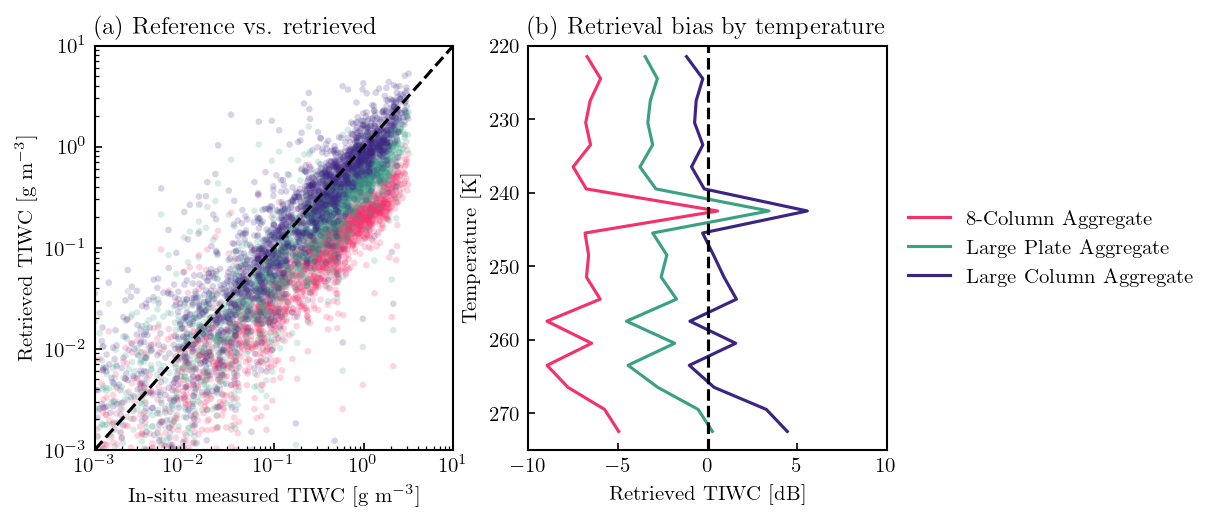

In [30]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(9, 3.5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.5], wspace=0.25)

ax = fig.add_subplot(gs[0, 0])
x = np.logspace(-3, 1, 101)
ax.plot(x, x, ls="--", c="k")
ax.scatter(tiwc_ref_8ca, tiwc_8ca, s=10, alpha=0.2, edgecolor="none")
ax.scatter(tiwc_ref_lpa, tiwc_lpa, s=10, alpha=0.2, edgecolor="none")
ax.scatter(tiwc_ref_lca, tiwc_lca, s=10, alpha=0.2, edgecolor="none")
ax.set_xlabel("In-situ measured TIWC [g m$^{-3}$]")
ax.set_ylabel("Retrieved TIWC [g m$^{-3}$]")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-3, 1e1)
ax.set_xlim(1e-3, 1e1)
ax.set_title("(a) Reference vs. retrieved", loc="left")

ax = fig.add_subplot(gs[0, 1])
temps = 0.5 * (t_bins[1:] + t_bins[:-1])

handles = []
handles += ax.plot(mean_err_8ca, temps, label="8-Column Aggregate")
handles += ax.plot(mean_err_lpa, temps, label="Large Plate Aggregate")
handles += ax.plot(mean_err_lca, temps, label="Large Column Aggregate")

ax.set_xlabel("Retrieved TIWC [dB]")
ax.set_ylabel("Temperature [K]")
ax.set_ylim(275, 220)
ax.axvline(0, ls="--", c="k")
ax.set_title("(b) Retrieval bias by temperature", loc="left")
ax.set_xlim(-10, 10)

ax = fig.add_subplot(gs[0, -1])
ax.set_axis_off()
ax.legend(handles=handles, edgecolor="none", facecolor="none", loc="center")
fig.savefig("../figures/haic_radar_retrieval.pdf", bbox_inches="tight")